# Imports

In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
import sounddevice as sd
import cv2

# Load Data

In [2]:
xdf_path = "C:/Users/Admin/Documents/CurrentStudy/sub-P001/ses-S001/stim/sub-P001_ses-S001_task-StimTest_run-001_stim.xdf"
#xdf_path = "C:/Users/Admin/Documents/CurrentStudy/sub-P666/ses-S001/mobi/sub-P666_ses-S001_task-Story_run-001_mobi.xdf"
#xdf_path = "C:/Users/Admin/Documents/CurrentStudy/sub-Pbryan/ses-S001/mic/sub-Pbryan_ses-S001_task-MicTest_run-001_mic.xdf"
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]
streams_collected

Stream 3: Calculated effective sampling rate 119.9960 Hz is different from specified rate 90.0000 Hz.


['WebcamStream', 'Stimuli_Markers', 'Tobii']

# Physio

In [11]:
PS = data[0]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['time'] = PS['time_stamps'] - PS['time_stamps'][0]

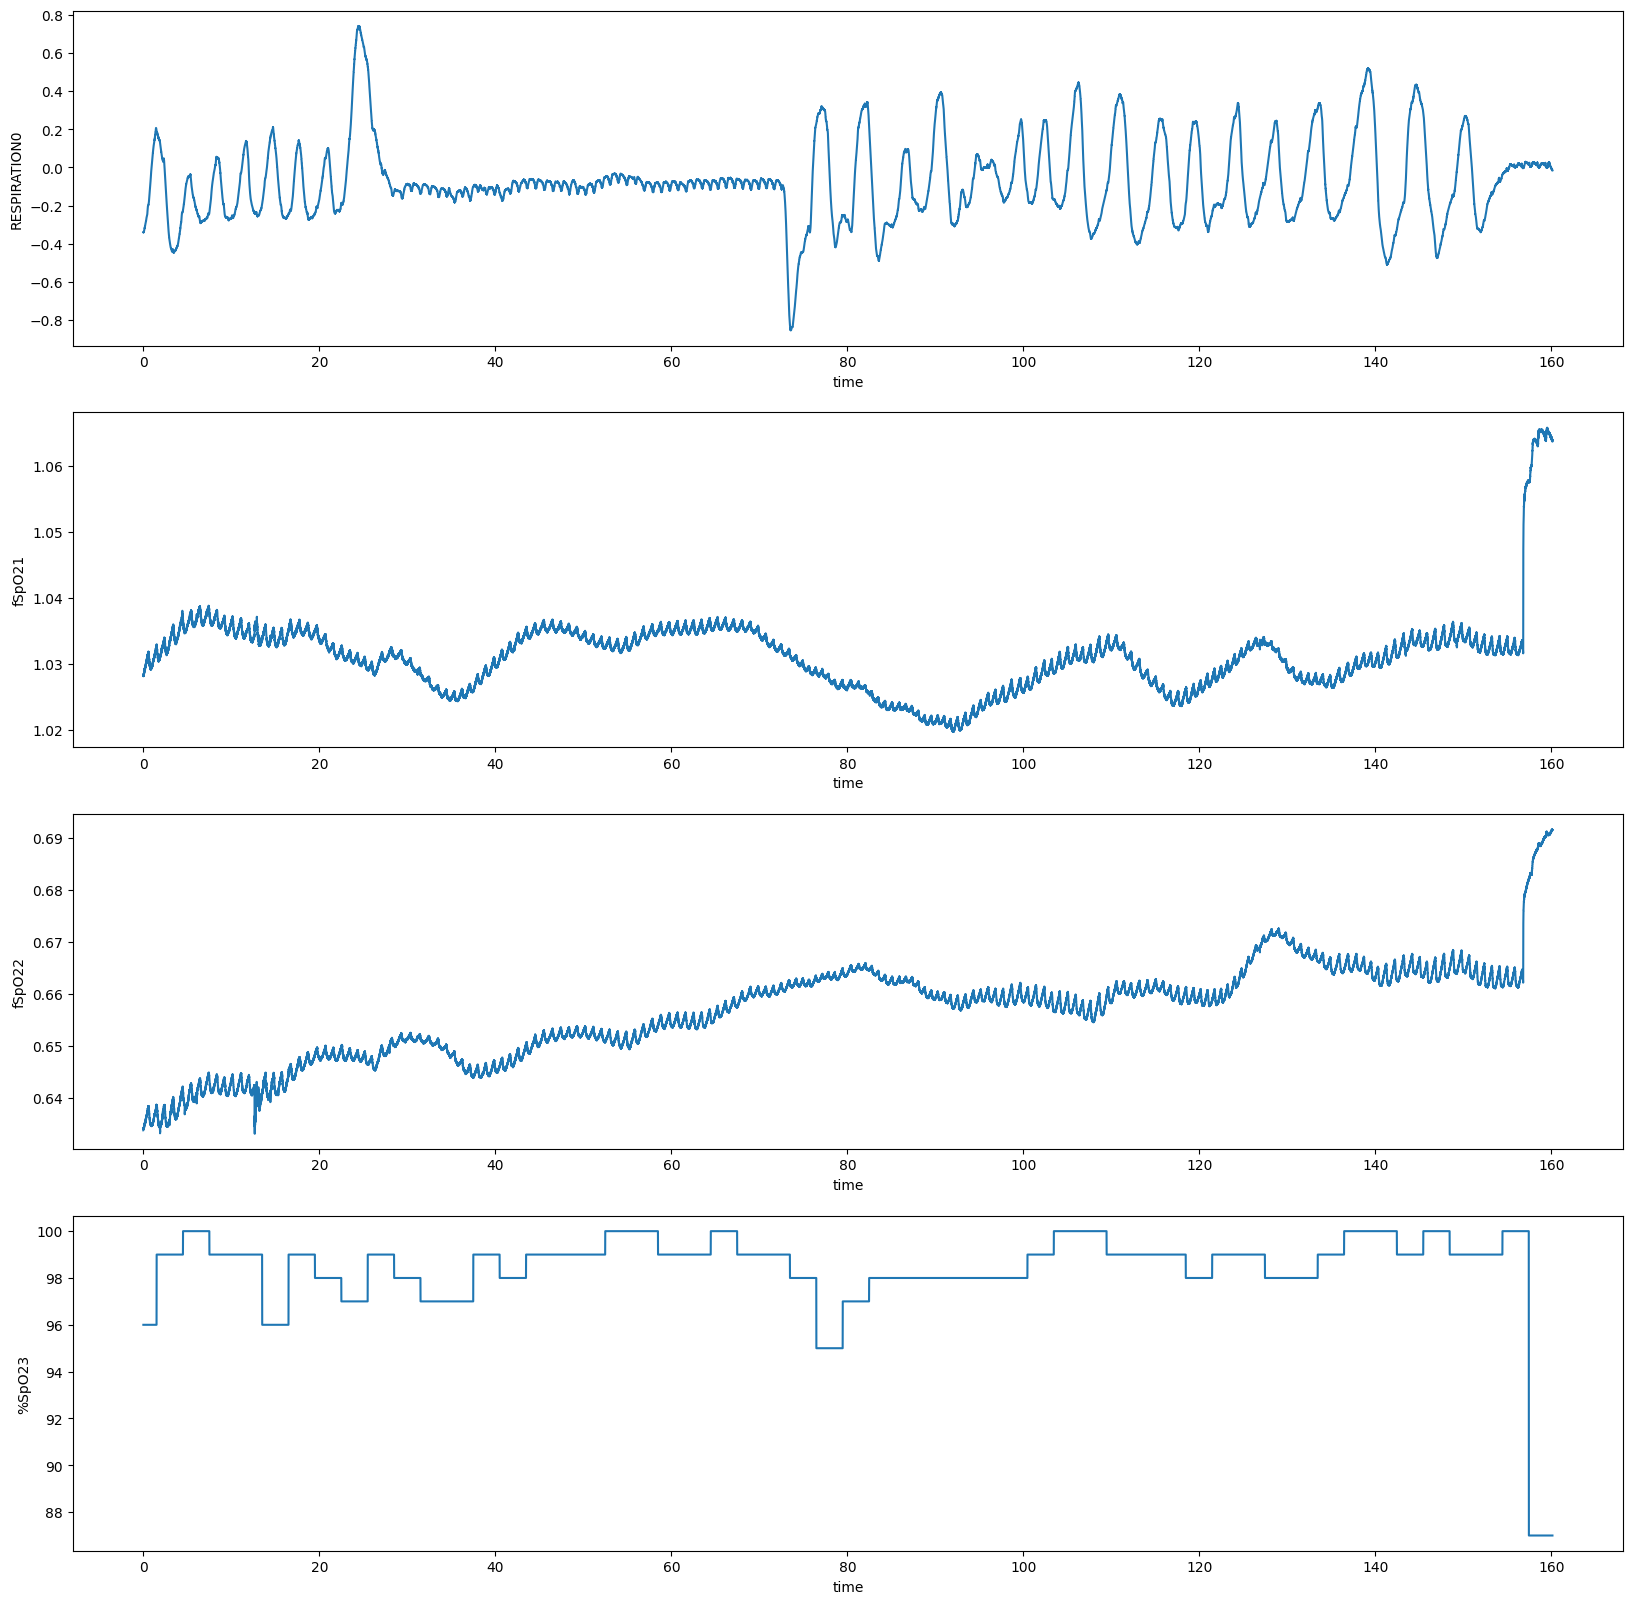

In [12]:
    
'''
# Plot every column in one plot
plt.figure(figsize=(20,10))
for col in ps_df.columns:
    plt.plot(ps_df['time'], ps_df[col])
plt.show()
'''
f, ax = plt.subplots(figsize=(20,20), nrows=4, ncols=1)

# Make this one figure with subplots
for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=ps_df, x='time', y=col, ax=ax[i])
    #plt.title(col)
    #plt.show()

In [30]:
#use the time column to get the sampling rate of each column
#ps_df['time'].diff().mean()
xx = ps_df['time'].diff().cumsum()

# Stimulus

## Stimulus Trigger Duration - Story Listening

In [6]:
stim_dat = data[1]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_ExperimentStart',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_ExperimentEnd',
}

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamps'] = stim_dat['time_stamps']
stim_df['time'] = stim_dat['time_stamps'] - stim_dat['time_stamps'][0]
stim_df

,trigger,event,lsl_time_stamps,time
0,200,Onset_ExperimentStart,1.477763e+06,0.000000
1,1723752430,psychopy_time_stamp,1.477763e+06,0.000010
2,1,Onset_RestingState,1.477766e+06,2.978783
3,1723752433,psychopy_time_stamp,1.477766e+06,2.978794
4,2,Offset_RestingState,1.478066e+06,302.978791
...,...,...,...,...
253,1723753283,psychopy_time_stamp,1.478616e+06,852.997818
254,201,Offset_ExperimentEnd,1.478618e+06,854.997767
255,1723753285,psychopy_time_stamp,1.478618e+06,854.997776
256,4,Offset_StoryListening,1.478618e+06,854.997900


In [8]:
# confirm all events are in the stim_df
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']


In [9]:
def get_secs_between_triggers(trigger1, trigger2):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

# Get a list of the story names using the events dict
#story_names = [x.split('_')[1] for x in list(events.values())[2:][::2]]
#story_names

story_onsets = list(events.keys())[2:][::2] #every other trigger is the offset
story_onsets

[10, 20, 30, 40, 50, 60, 70, 80]

In [8]:
files= [
    "../audio_files/audio_files/After_Searching_I_Found_and_Met_My_Birth_Mother.wav",
    "../audio_files/audio_files/Camp_Lose_A_Friend.wav",
    "../audio_files/audio_files/Frog_Dissection_Disaster.wav",
    "../audio_files/audio_files/I_Decided_To_Be_Myself_And_Won_A_Dance_Contest.wav",
    "../audio_files/audio_files/I_Fully_Embarrassed_Myself_In_Zoom_Class1.wav",
    "../audio_files/audio_files/Left_Home_Alone_in_a_Tornado.wav",
    "../audio_files/audio_files/The_Birthday_Party_Prank.wav",
    "../audio_files/audio_files/My_Dad_Saw_Me_Wearing_Glitter_At_School.wav"
]


durations = pd.DataFrame({
    'trigger':story_onsets,
    'story':[events[x] for x in story_onsets],
    'lsl_duration': [get_secs_between_triggers(x+1, x) for x in story_onsets],
    'audiofile_duration': [wave.open(x).getnframes()/wave.open(x).getframerate() for x in files] #duration of audio file is number of frames divided by the frame rate.
})

durations['difference(sec)'] = durations['audiofile_duration'] - durations['lsl_duration']
durations

IndexError: index 0 is out of bounds for axis 0 with size 0

## Stimulus Triggers - Social Script

In [3]:
stim_dat = data[4]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)

events = {100: 'Conversation_start', 
          101: 'Conversation_end'}

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 4 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 4, 'event'] = 'psychopy_time_stamp'
stim_df['time'] = stim_dat['time_stamps'] #- stim_dat['time_stamps'][0]

conversation_onset_stim = stim_df.loc[stim_df.event == 'Conversation_start', 'time'].values[0]
conversation_offset_stim = stim_df.loc[stim_df.event == 'Conversation_end', 'time'].values[0]
stim_df


,trigger,event,time
0,100,Conversation_start,341598.449366
1,1722616294,psychopy_time_stamp,341598.449377
2,101,Conversation_end,341899.951128
3,1722616595,psychopy_time_stamp,341899.951139


# Linking Microphone Data to Video Data

In [4]:
mic_data = data[5]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
mic_df['lsl_time_stamps'] = mic_data['time_stamps']
mic_df['time'] = mic_data['time_stamps'] #- mic_data['time_stamps'][0]
mic_df

,int_array,bytestring,lsl_time_stamps,time
0,-771,b'\xfd\xfc\xff\xff',341579.658152,341579.658152
1,-583,b'\xb9\xfd\xff\xff',341579.658174,341579.658174
2,-375,b'\x89\xfe\xff\xff',341579.658197,341579.658197
3,-154,b'f\xff\xff\xff',341579.658220,341579.658220
4,32,b' \x00\x00\x00',341579.658242,341579.658242
...,...,...,...,...
15174805,35,b'#\x00\x00\x00',341923.759080,341923.759080
15174806,-6,b'\xfa\xff\xff\xff',341923.759103,341923.759103
15174807,-4,b'\xfc\xff\xff\xff',341923.759125,341923.759125
15174808,18,b'\x12\x00\x00\x00',341923.759148,341923.759148


In [5]:

convo = mic_df.loc[(mic_df['time'] > conversation_onset_stim ) & (mic_df['time'] < conversation_offset_stim), 'int_array'].values



# Video Data
Now lets open the video frames

In [6]:
# Identify the frames we're interested in
cam_data = data[3]
#cam_df = pd.DataFrame(cam['time_series'], columns=['frame'])
#cam_df['lsl_timestamps'] = cam['time_stamps']
#cam_df['time'] = cam_df['lsl_timestamps'] - cam_df['lsl_timestamps'][0]
cam_data['time_series'][0]
frame_nums = [int(i[0]) for i in cam_data['time_series']]
time_pre = [float(i[1]) for i in cam_data['time_series']]
time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
time_post = [float(i[3]) for i in cam_data['time_series']]


cam_df = pd.DataFrame({'frame_num': frame_nums, 
                    'time_pre': time_pre, 
                    'cap_time_ms': time_evnt_ms,
                    'time_post': time_post,
                    'lsl_time_stamp': cam_data['time_stamps']})



cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp #- cam_df.lsl_time_stamp[0]
cam_df

,frame_num,time_pre,cap_time_ms,time_post,lsl_time_stamp,frame_time_sec,lsl_time_sec
0,1,1.722616e+09,2.533753e+08,1.722616e+09,341592.619618,0.000000,341592.619618
1,2,1.722616e+09,2.533754e+08,1.722616e+09,341592.652952,0.033333,341592.652952
2,3,1.722616e+09,2.533754e+08,1.722616e+09,341592.686285,0.066667,341592.686285
3,4,1.722616e+09,2.533754e+08,1.722616e+09,341592.719619,0.100000,341592.719619
4,5,1.722616e+09,2.533755e+08,1.722616e+09,341592.752952,0.133333,341592.752952
...,...,...,...,...,...,...,...
9419,9420,1.722617e+09,2.536893e+08,1.722617e+09,341906.588479,313.966667,341906.588479
9420,9421,1.722617e+09,2.536893e+08,1.722617e+09,341906.621813,314.000000,341906.621813
9421,9422,1.722617e+09,2.536894e+08,1.722617e+09,341906.655146,314.033333,341906.655146
9422,9423,1.722617e+09,2.536894e+08,1.722617e+09,341906.688480,314.066667,341906.688480


In [7]:
vid_convo = cam_df.loc[(cam_df['lsl_time_sec'] > conversation_onset_stim ) & (cam_df['lsl_time_sec'] < conversation_offset_stim)]
vid_convo_frames = vid_convo['frame_num'].values

A goal here is to identify timestamps in the microphone data and their corresponding frames in the video data

In [9]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/5555_CUNY_Face_SocialScript.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    sd.play(convo)
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            continue
    else:
        break


KeyboardInterrupt: 

In [1]:
def calc_luminance(r,g,b):
    return 0.2126*r + 0.7152*g + 0.0722*b

calc_luminance(128,128,128)

128.0

In [13]:
calc_luminance(100, 149, 2)

127.9692

In [16]:
calc_luminance(244, 81, 252)

128.0

In [15]:
for r in range(0, 255):
    for g in range(0, 255):
        for b in range(0, 255):
            if calc_luminance(r,g,b) == 128:
                print(r,g,b)

29 165 53
46 155 102
63 145 151
80 135 200
94 148 30
97 125 249
111 138 79
128 128 128
193 111 105
210 101 154
227 91 203
241 104 33
244 81 252
